In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft

In [3]:
#set parameters and initial conditions
numpoints=1000
numbinsx=32
numbinsy=32
deltat=0.1
numsteps=20
vt=np.zeros((2,numpoints))
np.random.seed(7)
points=np.random.normal(loc=8,scale=4,size=(2,round(numpoints/2)))
np.random.seed(42)
points=np.append(points,np.random.normal(loc=-8,scale=4,size=(2,round(numpoints/2))),axis=1)

In [4]:
#create bins
_,xedges,yedges=np.histogram2d(points[0],points[1],bins=(numbinsx,numbinsy)) #don't need the counts yet
deltax=xedges[1]-xedges[0]
deltay=yedges[1]-yedges[0]
binarea=deltax*deltay

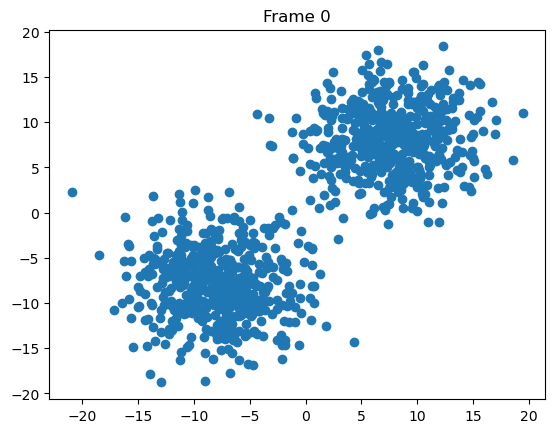

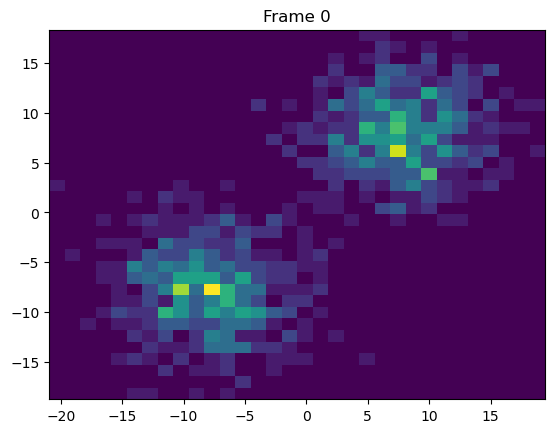

In [5]:
#do some plots to visualize initial conditions - method of saving images from chatgpt
plt.scatter(points[0],points[1])
plt.title(f"Frame {0}")
plt.savefig(f"Images/pointsframe_{0:03d}.png")
plt.close()
plt.hist2d(points[0],points[1],bins=[xedges,yedges])
plt.title(f"Frame {0}")
plt.savefig(f"Images/densityframe_{0:03d}.png")
plt.close()

In [6]:
for t in range(numsteps):
    #only thing that should pass from one life of the loop to the next is each points location and velocity
    #compute density
    counts=np.histogram2d(points[0],points[1],bins=(xedges,yedges))[0] #only need the counts now since edges are fixed
    density=counts/binarea

    #calculate which bin each point belongs to this found
    xlabels=np.digitize(points[0,:].round(5),xedges.round(5),right=True)
    ylabels=np.digitize(points[1,:].round(5),yedges.round(5),right=True)

    #do fourier transform
    fftdensity=fft.fft2(density)
    k=fft.fftfreq(numbinsx,deltax)
    l=fft.fftfreq(numbinsy,deltay)

    #solve for potential in fourier space
    fftpotential=np.zeros((numbinsx,numbinsy),dtype=complex)
    for i in range(numbinsx):
        for j in range(numbinsy):
            if k[i]==0 and l[j]==0:
                fftpotential[i,j]=0
            else:
                fftpotential[i,j]=-fftdensity[i,j]/(k[i]**2+l[j]**2)
                
    #do inverse fourier transform
    potential=np.fft.ifft2(fftpotential).real

    #calculate potential gradient
    potentialghosts=np.pad(potential, pad_width=1, mode='edge')
    gradx,grady=np.gradient(potentialghosts, deltax, deltay)

    #creating empty arrays for the t+dt values 
    vt1=np.zeros((2,numpoints))
    points1=np.zeros((2,numpoints))

    #update to leapfrog velocity method instead
    # for i in range(numpoints):
    #     #grab bin of current point
    #     ixbin=xlabels[i]
    #     iybin=ylabels[i]
    #      #update velocity by adding acceleration (negative potential gradient times deltat)
    #     vt1[0,i]=vt[0,i]-deltat*gradx[ixbin,iybin]
    #     vt1[1,i]=vt[1,i]-deltat*grady[ixbin,iybin]

    #move points to the next location
    points1=points+vt1*deltat

    #jump to the next time
    points,vt=points1,vt1

    #saving plot image - advice from chatgpt used
    plt.scatter(points[0],points[1])
    plt.title(f"Frame {(t+1)}")
    plt.savefig(f"Images/pointsframe_{(t+1):03d}.png")
    plt.close()
    plt.hist2d(points[0],points[1],bins=[xedges,yedges])
    plt.title(f"Frame {(t+1)}")
    plt.savefig(f"Images/densityframe_{(t+1):03d}.png")
    plt.close()

In [7]:
#make animations - from chatgpt 
import imageio.v2 as imageio

filenames = [f"Images/pointsframe_{i:03d}.png" for i in range(numsteps+1)]
with imageio.get_writer('Images/pointsanimation.gif', mode='I', duration=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

filenames = [f"Images/densityframe_{i:03d}.png" for i in range(numsteps+1)]
with imageio.get_writer('Images/densityanimation.gif', mode='I', duration=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)